Automated Simpson’s Paradox Detection

In [40]:
import pandas as pd
import numpy as np

# Initialize empty lists
departments = []
genders = []
admitted_status = []

# Parameters for Department A (harder department)
num_male_A = 8000
admission_rate_male_A = 0.125
num_female_A = 500
admission_rate_female_A = 0.10

# Parameters for Department B (easier department)
num_male_B = 500
admission_rate_male_B = 0.80
num_female_B = 1000
admission_rate_female_B = 0.75

print("Libraries imported and parameters defined.")

Libraries imported and parameters defined.


In [41]:
for _ in range(num_male_A):
    departments.append('A')
    genders.append('Male')
    admitted_status.append(1 if np.random.rand() < admission_rate_male_A else 0)

for _ in range(num_female_A):
    departments.append('A')
    genders.append('Female')
    admitted_status.append(1 if np.random.rand() < admission_rate_female_A else 0)

for _ in range(num_male_B):
    departments.append('B')
    genders.append('Male')
    admitted_status.append(1 if np.random.rand() < admission_rate_male_B else 0)

for _ in range(num_female_B):
    departments.append('B')
    genders.append('Female')
    admitted_status.append(1 if np.random.rand() < admission_rate_female_B else 0)

print("Synthetic data for Department A and B generated.")

Synthetic data for Department A and B generated.


In [42]:
df_paradox = pd.DataFrame({
    'Department': departments,
    'Gender': genders,
    'Admitted': admitted_status
})

print("DataFrame created. Displaying head and info:")
print(df_paradox.head())
print(df_paradox.info())

DataFrame created. Displaying head and info:
  Department Gender  Admitted
0          A   Male         0
1          A   Male         0
2          A   Male         0
3          A   Male         0
4          A   Male         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  10000 non-null  object
 1   Gender      10000 non-null  object
 2   Admitted    10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB
None


In [43]:
def calculate_association(df, outcome_col, exposure_col):

    # Calculate the mean of the outcome for each unique value in the exposure column
    group_means = df.groupby(exposure_col)[outcome_col].mean()

    # Ensure there are exactly two unique values as per assumption
    if len(group_means) != 2:
        raise ValueError(f"Expected exactly two unique values in '{exposure_col}', but found {len(group_means)}.")

    # Get the names of the two groups
    group_names = group_means.index.tolist()
    group1 = group_names[0]
    group2 = group_names[1]

    # Calculate the difference in means (success rates)
    # Convention: mean of the first group minus mean of the second group
    association = group_means[group1] - group_means[group2]

    return association

print("Function `calculate_association` defined.")

Function `calculate_association` defined.


In [44]:
def analyze_subgroups(df, outcome_col, exposure_col, group_col):

    subgroup_associations = {}

    unique_groups = df[group_col].unique()

    for group_value in unique_groups:
        subgroup_df = df[df[group_col] == group_value]
        # Ensure there's data in the subgroup before calculating association
        if not subgroup_df.empty:
            association = calculate_association(subgroup_df, outcome_col, exposure_col)
            subgroup_associations[group_value] = association
        else:
            subgroup_associations[group_value] = None # Or np.nan, or raise an error depending on desired behavior

    return subgroup_associations

print("Function `analyze_subgroups` defined.")

Function `analyze_subgroups` defined.


Overall Association (Exposure vs Outcome): 0.3477

Analyzing subgroups for grouping variable: 'Department'
  Subgroup 'A': Association = -0.0440 (Sign: -1.0)
  Subgroup 'B': Association = -0.0600 (Sign: -1.0)
  >>> SIMPSON'S PARADOX DETECTED for grouping variable 'Department'!

--- Simpson's Paradox Detected ---
Grouping Variable: Department
Overall Association (Gender vs Admitted): 0.3477
Overall Sign: 1.0

Subgroup Associations:
  - Subgroup 'A': Association = -0.0440 (Sign: -1.0)
  - Subgroup 'B': Association = -0.0600 (Sign: -1.0)


/tmp/ipython-input-1809908290.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='Admitted', data=overall_admission_rates, ax=axes[0], palette='viridis')


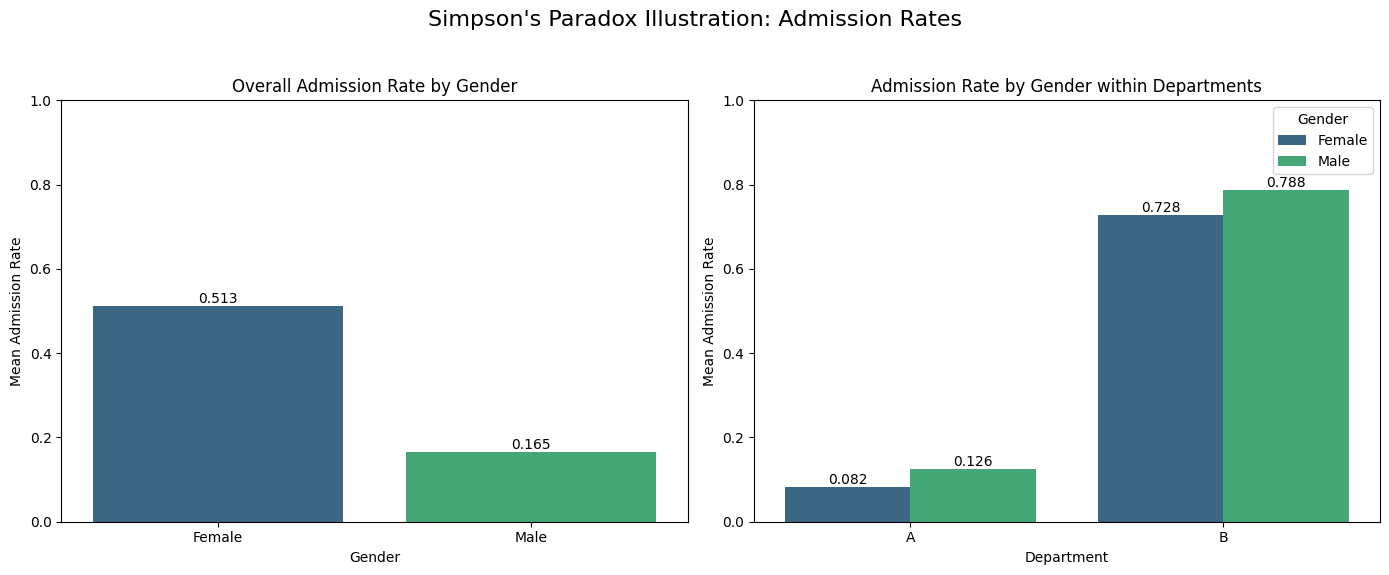

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

detected_paradoxes = detect_simpsons_paradox(df_paradox, 'Admitted', 'Gender', ['Department'])

for paradox in detected_paradoxes:
    print(f"\n--- Simpson's Paradox Detected ---")
    print(f"Grouping Variable: {paradox['grouping_variable']}")
    print(f"Overall Association (Gender vs Admitted): {paradox['overall_association']:.4f}")
    print(f"Overall Sign: {paradox['overall_sign']}")

    print(f"\nSubgroup Associations:")
    for detail in paradox['subgroup_associations']:
        if detail['association'] != 'N/A':
            print(f"  - Subgroup '{detail['subgroup']}': Association = {detail['association']:.4f} (Sign: {detail['sign']})")
        else:
            print(f"  - Subgroup '{detail['subgroup']}': Association = {detail['association']}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Simpson's Paradox Illustration: Admission Rates", fontsize=16)

    # Overall Admission Rate by Gender
    overall_admission_rates = df_paradox.groupby('Gender')['Admitted'].mean().reset_index()
    sns.barplot(x='Gender', y='Admitted', data=overall_admission_rates, ax=axes[0], palette='viridis')
    axes[0].set_title('Overall Admission Rate by Gender')
    axes[0].set_ylabel('Mean Admission Rate')
    axes[0].set_ylim(0, 1) # Admission rates are between 0 and 1
    for index, row in overall_admission_rates.iterrows():
        axes[0].text(index, row['Admitted'], f'{row["Admitted"]:.3f}', color='black', ha="center", va='bottom')

    # Admission Rate by Gender within Departments
    subgroup_admission_rates = df_paradox.groupby(['Department', 'Gender'])['Admitted'].mean().unstack().reset_index()
    subgroup_admission_rates_melted = subgroup_admission_rates.melt(id_vars='Department', var_name='Gender', value_name='Admitted')
    sns.barplot(x='Department', y='Admitted', hue='Gender', data=subgroup_admission_rates_melted, ax=axes[1], palette='viridis')
    axes[1].set_title(f'Admission Rate by Gender within {paradox['grouping_variable']}s')
    axes[1].set_ylabel('Mean Admission Rate')
    axes[1].set_ylim(0, 1)
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.3f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

Overall Association (Exposure vs Outcome): 0.3477

Analyzing subgroups for grouping variable: 'Department'
  Subgroup 'A': Association = -0.0440 (Sign: -1.0)
  Subgroup 'B': Association = -0.0600 (Sign: -1.0)
  >>> SIMPSON'S PARADOX DETECTED for grouping variable 'Department'!

--- Simpson's Paradox Detected ---
Grouping Variable: Department
Overall Association (Gender vs Admitted): 0.3477
Overall Sign: 1.0

Subgroup Associations:
  - Subgroup 'A': Association = -0.0440 (Sign: -1.0)
  - Subgroup 'B': Association = -0.0600 (Sign: -1.0)


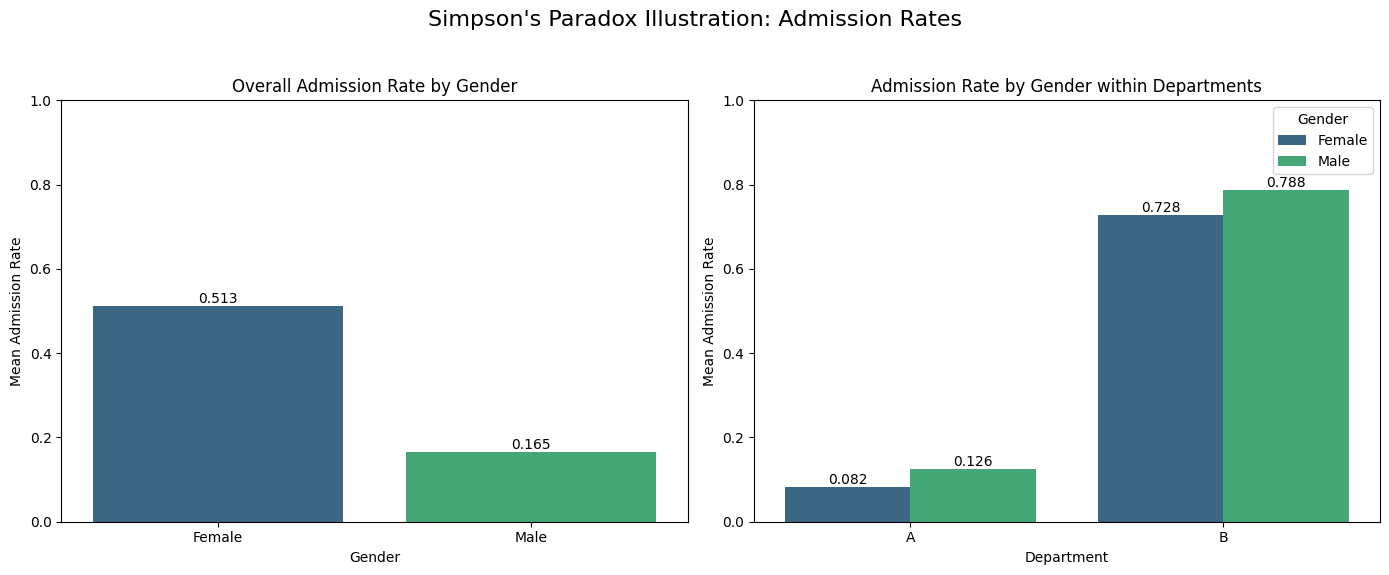

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

detected_paradoxes = detect_simpsons_paradox(df_paradox, 'Admitted', 'Gender', ['Department'])

for paradox in detected_paradoxes:
    print(f"\n--- Simpson's Paradox Detected ---")
    print(f"Grouping Variable: {paradox['grouping_variable']}")
    print(f"Overall Association (Gender vs Admitted): {paradox['overall_association']:.4f}")
    print(f"Overall Sign: {paradox['overall_sign']}")

    print(f"\nSubgroup Associations:")
    for detail in paradox['subgroup_associations']:
        if detail['association'] != 'N/A':
            print(f"  - Subgroup '{detail['subgroup']}': Association = {detail['association']:.4f} (Sign: {detail['sign']})")
        else:
            print(f"  - Subgroup '{detail['subgroup']}': Association = {detail['association']}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Simpson's Paradox Illustration: Admission Rates", fontsize=16)

    # Overall Admission Rate by Gender
    overall_admission_rates = df_paradox.groupby('Gender')['Admitted'].mean().reset_index()
    sns.barplot(x='Gender', y='Admitted', data=overall_admission_rates, ax=axes[0], hue='Gender', legend=False, palette='viridis')
    axes[0].set_title('Overall Admission Rate by Gender')
    axes[0].set_ylabel('Mean Admission Rate')
    axes[0].set_ylim(0, 1) # Admission rates are between 0 and 1
    for index, row in overall_admission_rates.iterrows():
        axes[0].text(index, row['Admitted'], f'{row["Admitted"]:.3f}', color='black', ha="center", va='bottom')

    # Admission Rate by Gender within Departments
    subgroup_admission_rates = df_paradox.groupby(['Department', 'Gender'])['Admitted'].mean().unstack().reset_index()
    subgroup_admission_rates_melted = subgroup_admission_rates.melt(id_vars='Department', var_name='Gender', value_name='Admitted')
    sns.barplot(x='Department', y='Admitted', hue='Gender', data=subgroup_admission_rates_melted, ax=axes[1], palette='viridis')
    axes[1].set_title(f"Admission Rate by Gender within {paradox['grouping_variable']}s")
    axes[1].set_ylabel('Mean Admission Rate')
    axes[1].set_ylim(0, 1)
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.3f')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()